In [1]:
import numpy as np
import random as rm
import pandas as pd
from random import seed
from random import random
import matplotlib.pyplot as plt
from pylab import *
from scipy.optimize import curve_fit
from scipy.stats import bernoulli, binom, norm
from scipy import integrate

### generalized toy example

In [3]:
# generalized toy example
def simulate(mu_list, sigma_list, n, alpha_list, p, y0, sigma, x0, epsilon):
    def f_pi(x):
        val = 0
        for i in range(len(mu_list)):
            val += alpha_list[i]*norm.pdf(x,mu_list[i], sigma_list[i]**0.5)
        return val

    def pdf_eta(x):
        return f_pi(x)**p

    c = integrate.quad(pdf_eta, -np.inf, np.inf)[0]
    
    def f_eta(x):
        return pdf_eta(x)/c
    
    def g(x):
        return(f_pi(x)/f_eta(x))
    
    def p_kernel(y0, sigma, n):
        count = 0
        Yn = y0
        estimator = [y0]
        while count<n:
            y = np.random.normal(Yn, sigma)
            u = np.random.uniform(0,1)
            alpha = min((pdf_eta(y)/pdf_eta(Yn)),1)
            if u <= alpha:
                estimator.append(y)
                Yn = y
                count += 1
        return estimator
    
    def k_kernel(x0, sigma):
        count = 0
        Xn = x0
        estimator = [x0]
        while count<1:
            y = np.random.normal(Xn,sigma)
            u = np.random.uniform(0,1)
            alpha = min((pdf_eta(y)/pdf_eta(Xn)),1)
            if u <= alpha:
                estimator.append(y)
                Xn = y
                count += 1
        return estimator[-1]
    
    def sum_g(sum_old, yn):
        sum_new = sum_old + g(yn)
        return sum_new

    def prob_list(y, sum_new):
        prob_list = []
        for i in y:
            prob_list.append(g(i)/sum_new)
        return prob_list
    
    def bernoulli_list(epsilon, n):
        b_list = bernoulli(epsilon).rvs(n)
        return b_list
    
    def x_sample(x0, epsilon, y0, n, sigma):
        X_list = [x0]
        Y_list = [y0]
        sum_gs = g(y0)
        Y_list = p_kernel(y0,sigma,n)
        for k in range(1, n):
            sum_gs = sum_g(sum_gs, Y_list[k])
            prob_list_Ys = prob_list(Y_list[:k+1], sum_gs)
            bernoullis = bernoulli_list(epsilon, 1)
            i = bernoullis
            if i == 0:
                X_list.append(k_kernel(x0, sigma))
            if i == 1:
                X_list.append(np.random.choice(Y_list[:k+1], p = prob_list_Ys))
            x0 = X_list[-1]
        return X_list
    
    def E_x(X_list):
        sum = 0
        for i in X_list:
            sum += i
        mean = sum/len(X_list)
        return mean
    
    X_list = x_sample(x0, epsilon, y0, n, sigma)
    mean = E_x(X_list)
    
    return [X_list, mean]

In [9]:
mu_list = [0,17.5]
sigma_list = [.5,1]
alpha_list = [0.4,0.6]
p = 0.75
n = 200
y0 = 15
x0 = 10
sigma = 10
epsilon = 0.05

X_list = simulate(mu_list, sigma_list, n, alpha_list, p, y0, sigma, x0, epsilon)[0]
mean = simulate(mu_list, sigma_list, n, alpha_list, p, y0, sigma, x0, epsilon)[1]

In [10]:
print(mean)

11.664919592198505


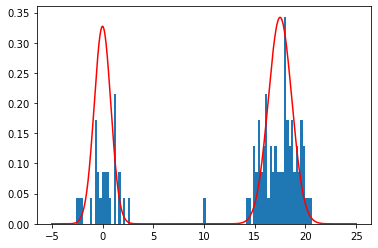

In [8]:
# plot
pdf_eta = lambda x: np.power(0.4*(1/np.sqrt(2*math.pi*0.5))*np.exp((-1/2)*((x-0)**2/0.5)) + 0.6*(1/np.sqrt(2*math.pi*1))*np.exp((-1/2)*((x-17.5)**2/1)),0.75)

plt.hist(X_list, density = True, bins = 100)
t = np.linspace(-5,25,1000)
vals = pdf_eta(t)
plt.plot(t,vals, 'r')

### many particles, $x_i$ with $y_i$

In [21]:
# x_i move according to y_i
def simulate_list1(mu_list, sigma_list, n, alpha_list, p, y0_list, sigma, x0_list, epsilon, N):
    def f_pi(x):
        val = 0
        for i in range(len(mu_list)):
            val += alpha_list[i]*norm.pdf(x,mu_list[i], sigma_list[i]**0.5)
        return val

    def pdf_eta(x):
        return f_pi(x)**p

    c = integrate.quad(pdf_eta, -np.inf, np.inf)[0]
    
    def f_eta(x):
        return pdf_eta(x)/c
    
    def g(x):
        return(f_pi(x)/f_eta(x))
    
    '''
    def p_kernel_adjust(y0_list, sigma, n):
        Yn_list = y0_list
        estimator_matrix = np.empty((0,n), int)
        for i in range(len(Yn_list)):
            count = 0
            estimator_list = [y0_list[i]]
            Yn_list = y0_list
            while count<n:
                y = np.random.normal(Yn_list[i], sigma)
                u = np.random.uniform(0,1)
                alpha = (min((pdf_eta(y)/pdf_eta(Yn_list[i])),1))
                if u <= alpha:
                    estimator_list.append(y)
                    Yn_list[i] = y
                    count += 1
            estimator_matrix = np.append(estimator_matrix, [estimator_list[1:]], axis=0)
        return estimator_matrix

    def k_kernel_adjust(x0_list,sigma):
        Xn_list = x0_list
        estimator_matrix = np.empty((0,2), int)
        for i in range(len(Xn_list)):
            count = 0
            estimator_list = [x0_list[i]]
            Xn_list = x0_list
            while count<1:
                y = np.random.normal(Xn_list[i],sigma)
                u = np.random.uniform(0,1)
                alpha = min((pdf_eta(y)/pdf_eta(Xn_list[i])),1)
                if u <= alpha:
                    estimator_list.append(y)
                    Xn_list[i] = y
                    count +=1
            estimator_matrix = np.append(estimator_matrix, [estimator_list], axis=0)
        return estimator_matrix
    ##
    '''
    
    def p_kernel(y0, sigma, n):
        count = 0
        Yn = y0
        estimator = [y0]
        while count<n:
            y = np.random.normal(Yn, sigma)
            u = np.random.uniform(0,1)
            alpha = min((pdf_eta(y)/pdf_eta(Yn)),1)
            if u <= alpha:
                estimator.append(y)
                Yn = y
                count += 1
        return estimator
    
    def k_kernel(x0, sigma):
        count = 0
        Xn = x0
        estimator = [x0]
        while count<1:
            y = np.random.normal(Xn,sigma)
            u = np.random.uniform(0,1)
            alpha = min((pdf_eta(y)/pdf_eta(Xn)),1)
            if u <= alpha:
                estimator.append(y)
                Xn = y
                count += 1
        return estimator[-1]
    
    def sum_g(sum_old, yn):
        sum_new = sum_old + g(yn)
        return sum_new

    def prob_list(y, sum_new):
        prob_list = []
        for i in y:
            prob_list.append(g(i)/sum_new)
        return prob_list
    
    def bernoulli_list(epsilon, n):
        b_list = bernoulli(epsilon).rvs(n)
        return b_list
    
    def x_sample(x0_list, epsilon, y0_list, n, sigma, N):
        X_matrix = np.empty((0,n),int)
        Y_matrix = np.empty((0,n),int)
        for i in range(N):
            sum_gs = g(y0_list[i])
            X_list = [x0_list[i]]
            Y_list = p_kernel(y0_list[i], sigma, n)
            for k in range(1, n):
                sum_gs = sum_g(sum_gs, Y_list[k])
                prob_list_Ys = prob_list(Y_list[:k+1], sum_gs)
                j = bernoulli_list(epsilon, 1)
                if j == 0:
                    X_list.append(k_kernel(x0_list[i], sigma))
                if j == 1:
                    X_list.append(np.random.choice(Y_list[:k+1], p = prob_list_Ys))
            X_matrix = np.append(X_matrix, [X_list], axis=0)
            x0_list[i] = X_matrix[i][-1]
        return X_matrix
    
    def E_x(X_matrix):
        sum_matrix = X_matrix.sum()
        len_matrix = X_matrix.size
        average_matrix = sum_matrix/len_matrix
        return average_matrix
    
    X_matrix = x_sample(x0_list, epsilon, y0_list, n, sigma, N)
    mean = E_x(X_matrix)
    
    return X_matrix.flatten(),mean

In [26]:
mu_list = [0,17.5]
sigma_list = [.5,1]
alpha_list = [0.4,0.6]
p = 0.75
n = 50
y0_list = [15, 5, 2, 1, 2]
x0_list = [10,3,4,-2,3]
sigma = 10
epsilon = 0.05
N = 5

y1_list = [15, 7, 1, 11, 14]
x1_list = [10,1,5,8,11]

b = simulate_list1(mu_list, sigma_list, n, alpha_list, p, y1_list, sigma, x1_list, epsilon, N)[0]
print(b)


[ 1.00000000e+01  1.57307285e+01  1.63558341e+01  2.39511407e+01
  1.49023388e+01  1.39789773e+01  1.05732450e+01  1.75835490e+01
  5.07161520e+00  2.09508023e+01  1.84934090e+01  1.83211435e+01
  1.12258442e+01  1.42890502e+01  1.79474120e+00  1.90127247e+01
  2.99214379e+00  1.63776203e+01  2.00608710e+01 -2.26543143e-02
  1.15148723e+01  1.99187067e+01  3.47156150e+00 -1.90531490e+00
  1.71848911e+01  2.08775099e+01  1.21179973e+01  2.10290642e+01
 -2.15258778e+00  1.52930133e+01  2.12865588e+01  2.08612363e+01
  2.49637166e+01  1.58886924e+01 -8.39862600e-01  1.33724039e+01
  1.94892914e+01  2.06724199e+01  1.01323820e+01  2.19838008e+01
  2.42540594e+01  1.42267848e+01  1.32916199e+01  1.39003467e+01
  1.95879400e+01  2.21818193e+01  1.06869226e+01  1.17360185e+01
  1.34340836e+00  5.46202991e+00  1.00000000e+00  1.69421980e+01
  1.12087137e+00  1.36372204e+00  6.30528711e-01  1.61791955e+01
  8.82439212e-01  1.78119595e+01 -1.45867026e+00  1.59789286e+01
 -8.18064639e-01  5.67645

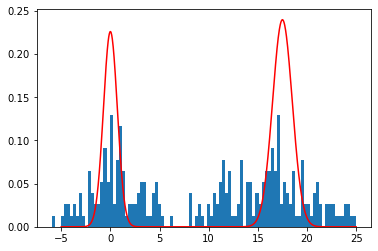

In [28]:
# plot
#pdf_eta = lambda x: np.power(0.4*(1/np.sqrt(2*math.pi*0.5))*np.exp((-1/2)*((x-0)**2/0.5)) + 0.6*(1/np.sqrt(2*math.pi*1))*np.exp((-1/2)*((x-17.5)**2/1)),0.75)
pdf_pi = lambda x: 0.4*(1/np.sqrt(2*math.pi*0.5))*np.exp((-1/2)*((x-0)**2/0.5)) + 0.6*(1/np.sqrt(2*math.pi*1))*np.exp((-1/2)*((x-17.5)**2/1))
plt.hist(b, density = True, bins = 100)
t = np.linspace(-5,25,1000)
vals = pdf_pi(t)
plt.plot(t,vals, 'r')

### all $ys$ past positions

In [44]:
# x_i move according to all ys
def simulate_list2(mu_list, sigma_list, n, alpha_list, p, y0_list, sigma, x0_list, epsilon, N):
    def f_pi(x):
        val = 0
        for i in range(len(mu_list)):
            val += alpha_list[i]*norm.pdf(x,mu_list[i], sigma_list[i]**0.5)
        return val

    def pdf_eta(x):
        return f_pi(x)**p

    c = integrate.quad(pdf_eta, -np.inf, np.inf)[0]
    
    def f_eta(x):
        return pdf_eta(x)/c
    
    def g(x):
        return(f_pi(x)/f_eta(x))
    
    def p_kernel(y0, sigma, n):
        count = 0
        Yn = y0
        estimator = [y0]
        while count<n:
            y = np.random.normal(Yn, sigma)
            u = np.random.uniform(0,1)
            alpha = min((pdf_eta(y)/pdf_eta(Yn)),1)
            if u <= alpha:
                estimator.append(y)
                Yn = y
                count += 1
        return estimator
    
    def k_kernel(x0, sigma):
        count = 0
        Xn = x0
        estimator = [x0]
        while count<1:
            y = np.random.normal(Xn,sigma)
            u = np.random.uniform(0,1)
            alpha = min((pdf_eta(y)/pdf_eta(Xn)),1)
            if u <= alpha:
                estimator.append(y)
                Xn = y
                count += 1
        return estimator[-1]
    
    def sum_g(sum_old, yn):
        sum_new = sum_old + g(yn)
        return sum_new
    
    def prob_matrix(Y_matrix, sum_new):
        prob_matrix = np.zeros((len(Y_matrix),len(Y_matrix[0])))
        for i in range(len(Y_matrix[0])):
            for j in range(len(Y_matrix)):
                prob_matrix[j][i] = g(Y_matrix[j][i])/sum_new
        return prob_matrix
    
    def bernoulli_list(epsilon, n):
        b_list = bernoulli(epsilon).rvs(n)
        return b_list
    
    def x_sample(x0_list, epsilon, y0_list, n, sigma, N):
        X_matrix = np.zeros((N,n))
        Y_matrix = np.zeros((N,n))
        sum_Gs = 0
        for i in range(n):
            sum_gs = 0
            for j in range(N):
                if i == 0:
                    Y_matrix[j][i] = y0_list[j]
                    sum_gs = sum_g(sum_gs, y0_list[j])
                else:
                    Y_matrix[j][i] = p_kernel(y0_list[j], sigma, 1)[-1]
                    y0_list[j] = Y_matrix[j][-1]
                    sum_gs = sum_g(sum_gs, Y_matrix[j][i])
            sum_Gs += sum_gs
            Prob_matrix = prob_matrix(Y_matrix[:,0:i+1], sum_Gs)
            Y_matrix_flatten = Y_matrix[:,0:i+1].flatten()
            Prob_matrix_flatten = Prob_matrix.flatten()
            for j in range(N):
                b = bernoulli_list(epsilon, 1)
                if b == 0:
                    X_matrix[j][i] = k_kernel(x0_list[j], sigma)
                if b == 1:
                    X_matrix[j][i] = np.random.choice(Y_matrix_flatten, p = Prob_matrix_flatten)
                x0_list[j] = X_matrix[j][-1]
        # return X_matrix
    
    def E_x(X_matrix):
        sum_matrix = X_matrix.sum()
        len_matrix = X_matrix.size
        average_matrix = sum_matrix/len_matrix
        return average_matrix
        
    X_matrix = x_sample(x0_list, epsilon, y0_list, n, sigma, N)
    mean = E_x(X_matrix)
    
    return X_matrix
    

In [46]:
mu_list = [0,17.5]
sigma_list = [.5,1]
alpha_list = [0.4,0.6]
p = 0.75
n = 10
y0_list = [15, 5, 2, 1, 2]
x0_list = [10,10,4,-2,3]
sigma = 10
epsilon = 0.05
N = 7

y1_list = [25, 13, 12, 11, 14,15,0]
x1_list = [10,12,8,9,11,12,10]

a = simulate_list2(mu_list, sigma_list, n, alpha_list, p, y1_list, sigma, x1_list, epsilon, N)
print(a)

[[ 1.49726992e+01  1.55838493e+01  4.07902231e-01  1.38504826e+00
  -2.44625051e-01 -5.55261715e-01  1.64607425e+01  2.33507131e-01
   2.33081900e+01 -2.82906912e-01]
 [-1.58597845e+00  2.62087545e-01  8.32397081e-01 -7.03563375e-01
   1.87628351e+01  8.84072071e-02 -2.05156445e-01  1.73861318e+01
   1.65835233e+00  1.90823339e+01]
 [ 3.13212084e+00  9.04049015e-01 -2.91028842e-01  1.79812626e+01
  -6.70824102e-01 -5.98113440e-01  9.80598005e-01 -1.69378281e+00
  -4.31229280e-01  1.73979910e+01]
 [ 1.09474979e+01  6.41725838e-03 -2.74646245e-01  1.18935355e+00
  -4.60105467e-01  1.69142013e+01 -1.61646406e+00 -1.41450988e+00
  -6.10849089e-01 -1.32193401e-01]
 [ 1.26620333e+01 -6.68995333e-01 -3.49099414e-01 -6.94908326e-01
   1.73025409e-01  6.29524403e-01  3.31996678e-01  2.02399296e-01
  -6.38008612e-01 -4.35220923e-01]
 [ 2.15325113e+01  9.50454642e-02 -1.72094890e+00  1.70786688e+01
  -8.23143125e-01 -4.50531915e-01 -6.06245315e-02 -1.25283912e-02
   1.71108650e+01  2.82034501e-02

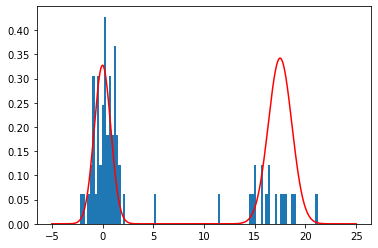

In [43]:
# plot
pdf_eta = lambda x: np.power(0.4*(1/np.sqrt(2*math.pi*0.5))*np.exp((-1/2)*((x-0)**2/0.5)) + 0.6*(1/np.sqrt(2*math.pi*1))*np.exp((-1/2)*((x-17.5)**2/1)),0.75)

plt.hist(a, density = True, bins = 100)
t = np.linspace(-5,25,1000)
vals = pdf_eta(t)
plt.plot(t,vals, 'r')